In [1]:
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import copy, time
import random
import pickle
import scipy

import mlrfit as mf
import hfmfit as hf
import numba as nb

from scipy.sparse import coo_matrix
from scipy.linalg import block_diag, pinvh

/Users/parshakova.tanya/opt/anaconda3/envs/routing/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
np.random.seed(1001)
random.seed(1001)

# True model is MLR factor model with SNR = 4 

Let $\Sigma = FF^T + D$ be MLR. We generate samples using 
$$
y = Fz + e, \qquad z \sim N(0, I), \qquad N(0, D).
$$

In [3]:
mtype = "small_mlr_hier"
n = 200
signal_to_noise = 4


nsamples = 20
L = 5

ranks = np.array([5, 4, 3, 2, 1])
rank = ranks.sum()

In [4]:
pi_rows = np.random.permutation(n)
hpart = {'rows':{'pi':pi_rows, 'lk':[]}, 'cols':{'pi':pi_rows, 'lk':[]}} 
for ngroups in [2, 5, 9, 17, n+1]:
       hpart['rows']['lk'] += [ np.linspace(0, n, ngroups, endpoint=True, dtype=int)]
hpart['rows']['lk'][1] = np.delete(hpart['rows']['lk'][1], -2)
hpart['rows']['lk'][2] = np.delete(hpart['rows']['lk'][2], -4)
hpart['cols']['lk'] = hpart['rows']['lk']
part_sizes = hf.print_hpart_numgroups(hpart)

level=0, num_groups=1, mean_size=200.0
level=1, num_groups=3, mean_size=66.7
level=2, num_groups=7, mean_size=28.6
level=3, num_groups=16, mean_size=12.5
level=4, num_groups=200, mean_size=1.0


In [5]:
hpart['rows']['lk'][:-1]

[array([  0, 200]),
 array([  0,  50, 100, 200]),
 array([  0,  25,  50,  75, 100, 150, 175, 200]),
 array([  0,  12,  25,  37,  50,  62,  75,  87, 100, 112, 125, 137, 150,
        162, 175, 187, 200])]

In [6]:
true_mlr, true_sparse_F, true_D_noise = hf.generate_mlr_model(n, hpart, ranks, signal_to_noise)
true_compressed_F = true_mlr.B[:, :-1]

signal_var=14.018864042024738, noise_var=3.7482808971794013
SNR=3.74007829898074, signal_to_noise=4


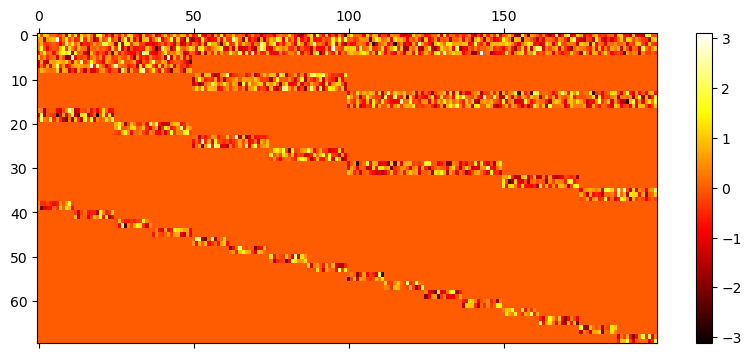

(200, 70)


In [7]:
plt.figure(figsize=(10, 4)) 
plt.matshow(true_sparse_F.T, aspect='auto', fignum=1, cmap='hot') 
plt.colorbar() 
plt.show()
print(true_sparse_F.shape)

In [8]:
type(true_sparse_F)

numpy.ndarray

In [9]:
filename = "%s_r%d_%d"%(mtype, rank, n)

In [10]:
row_selectors, si_groups, F_hpart, groups_all = hf.row_col_selections(hpart, return_groups=True)

num_levels=5, num_sparsities=16
(16, 4) [ 0  2  6 15]


In [11]:
for level_A in range(len(F_hpart["lk"])): 
    for level_B in range(level_A+1):
        lk_A = F_hpart['lk'][level_A]
        lk_B = F_hpart['lk'][level_B]
        A = true_compressed_F[:,ranks[:level_A].sum():ranks[:level_A+1].sum()]
        B = true_compressed_F[:,ranks[:level_B].sum():ranks[:level_B+1].sum()]
        
        AtB = hf.block_diag_lk(lk_A, A).T @  hf.block_diag_lk(lk_B, B)
        res = hf.mult_blockdiag_refined_AtB(A, lk_A, B, lk_B)
        # res2 = jit_mult_blockdiag_refined_AtB(A, lk_A, B, lk_B)
        # indices of groups in A that refine groups in B
        indices_A2B = np.searchsorted(lk_A, lk_B, side='left') * ranks[level_A]
        assert np.allclose(AtB, hf.block_diag_lk(indices_A2B, res)) 
        # assert np.allclose(AtB, block_diag_lk(indices_A2B, res2))

        AAt = hf.block_diag_FFt(level_A, F_hpart, A)
        assert np.allclose(AAt, hf.block_diag_AB(lk_A, A, A.T)) and np.allclose(AAt, hf.block_diag_lk(lk_A, A) @ hf.block_diag_lk(lk_A, A).T)

print("PASSED")

PASSED


In [12]:
F_Lm1, D = true_compressed_F+0, true_D_noise+0
v = np.random.randn(n)

In [13]:
v_F_Lm1 = np.concatenate([v[:, np.newaxis], F_Lm1], axis=1)
prev_l_recurrence = (1/D[:, np.newaxis]) * v_F_Lm1
ranks_v = ranks + 0
ranks_v[0] += 1

sparse_v_F_lm1 = np.concatenate([v[:, np.newaxis], true_sparse_F], axis=1)
sparse_prev_l_recurrence = (1/D[:, np.newaxis]) * sparse_v_F_lm1
assert np.allclose(np.diag(1/D) @ true_compressed_F, prev_l_recurrence[:, 1:])
assert np.allclose(sparse_prev_l_recurrence, hf.compressed2sparse_recurrence(prev_l_recurrence, F_hpart["lk"], ranks_v))

In [14]:
size_v_F_l = np.array([F_hpart["lk"][l].size-1 for l in range(L-1)]) * ranks_v[:-1]
for level in reversed(range(1, L-1)):
    print(f"{level=}")
    pl = F_hpart['lk'][level].size - 1
    rl = ranks[level]
    assert prev_l_recurrence.shape == (n, 1 + ranks[:level+1].sum())
    assert np.allclose(sparse_prev_l_recurrence, hf.compressed2sparse_recurrence(prev_l_recurrence, F_hpart["lk"][:level+1], ranks_v[:level+1]))
    # M0 same sparsity as Fl
    M0 = prev_l_recurrence[:, -ranks_v[level]:]

    # M1 = M0.T @ rec_term, same sparsity as rec_term
    M1 = np.zeros((rl * pl, 1 + ranks[:level].sum()))
    for lp in range(level):
        M1[:, ranks_v[:lp].sum() : ranks_v[:lp+1].sum()] = hf.mult_blockdiag_refined_AtB(M0, 
                                                                                      F_hpart['lk'][level], 
                                                                                      v_F_Lm1[:,ranks_v[:lp].sum():ranks_v[:lp+1].sum()], F_hpart['lk'][lp])
    # check M1 computation
    sparse_M0 = sparse_prev_l_recurrence[:, size_v_F_l[:level].sum():size_v_F_l[:level+1].sum()]
    sparse_M1 = sparse_M0.T @ sparse_v_F_lm1[:, :size_v_F_l[:level].sum()]
    M1_lks = [np.searchsorted(F_hpart['lk'][level], lk_B, side='left') * rl for lk_B in F_hpart['lk'][:level]]
    assert np.allclose(sparse_M1, hf.compressed2sparse_recurrence(M1, M1_lks, ranks_v[:level]))
    # del sparse_M0, sparse_M1


    # M2 = (I + Fl^T M0)^{-1}, blockdiagonal with pl blocks of size (rl x rl)
    FlTM0 = hf.mult_blockdiag_refined_AtB(v_F_Lm1[:,ranks_v[:level].sum():ranks_v[:level+1].sum()], 
                                       F_hpart['lk'][level], 
                                       M0, 
                                       F_hpart['lk'][level])
    # check Fl^TM0 computation
    sparse_FlTM0 = sparse_v_F_lm1[:, size_v_F_l[:level].sum():size_v_F_l[:level+1].sum()].T @ sparse_M0
    assert np.allclose(sparse_FlTM0, hf.block_diag_lk(np.linspace(0, pl*rl, num=pl+1, endpoint=True, dtype=int), FlTM0))
    M2 = np.zeros((pl*rl, rl))
    for k in range(pl):
        np.fill_diagonal(FlTM0[k*rl : (k+1)*rl], FlTM0[k*rl : (k+1)*rl].diagonal() + 1)
        M2[k*rl : (k+1)*rl] = pinvh(FlTM0[k*rl : (k+1)*rl])
    # check M2 computation, symmetric PD matrix
    sparse_M2 = np.linalg.inv(np.eye(rl*pl) + sparse_FlTM0)
    assert np.allclose(sparse_M2, hf.block_diag_lk(np.linspace(0, pl*rl, num=pl+1, endpoint=True, dtype=int), M2))


    # M3 = M2 @ M1, same sparsity as M1
    M3 = np.zeros((rl * pl, 1 + ranks[:level].sum()))
    for lp in range(level):
        M3[:, ranks_v[:lp].sum():ranks_v[:lp+1].sum()] = hf.mult_blockdiag_refined_AtB(M2, 
                                                                                    np.linspace(0, pl*rl, num=pl+1, endpoint=True, dtype=int), 
                                                                                    M1[:,ranks_v[:lp].sum():ranks_v[:lp+1].sum()], 
                                                                                    M1_lks[lp])
    # check M3 computation
    sparse_M3 = sparse_M2 @ sparse_M1
    assert np.allclose(sparse_M3, hf.compressed2sparse_recurrence(M3, M1_lks, ranks_v[:level]))


    # M4 = M0 @ M3, same sparsity as current rec_term
    M4 = np.zeros((n, 1 + ranks[:level].sum()))
    for lp in range(level):
        M4[:, ranks_v[:lp].sum() : ranks_v[:lp+1].sum()] = hf.mult_blockdiag_refined_AB(M0, 
                                                                                      F_hpart["lk"][level], 
                                                                                      M3[:,ranks_v[:lp].sum():ranks_v[:lp+1].sum()], 
                                                                                      M1_lks[lp])
    # check M4 computation
    sparse_M4 = sparse_M0 @ sparse_M3
    assert np.allclose(sparse_M4, hf.compressed2sparse_recurrence(M4, F_hpart["lk"][:level], ranks_v[:level]))


    # M5 
    prev_l_recurrence = prev_l_recurrence[:, :ranks_v[:level].sum()] - M4
    # check M5 computation
    sparse_prev_l_recurrence = sparse_prev_l_recurrence[:, :size_v_F_l[:level].sum()] - sparse_M4
    assert np.allclose(sparse_prev_l_recurrence, hf.compressed2sparse_recurrence(prev_l_recurrence, F_hpart["lk"][:level], ranks_v[:level]))
    
print("PASSED")

level=3


level=2
level=1
PASSED


In [15]:
prev_l_recurrence[:, -ranks[0]:].shape

(200, 5)

In [16]:
# final level=0 
level = 0
pl = F_hpart['lk'][level].size - 1
rl = ranks[level]
assert prev_l_recurrence.shape == (n, 1 + ranks[:level+1].sum())
assert np.allclose(sparse_prev_l_recurrence, hf.compressed2sparse_recurrence(prev_l_recurrence, F_hpart["lk"][:level+1], ranks_v[:level+1]))
# M0 same sparsity as Fl
M0 = prev_l_recurrence[:, -ranks[level]:]

# M1 = M0.T @ rec_term, same sparsity as rec_term
M1 = hf.mult_blockdiag_refined_AtB(M0, 
                                F_hpart['lk'][level], 
                                v[:, np.newaxis], 
                                F_hpart['lk'][0])
# check M1 computation
sparse_M0 = sparse_prev_l_recurrence[:, 1:size_v_F_l[:level+1].sum()]
sparse_M1 = sparse_M0.T @ v[:, np.newaxis] 
assert np.allclose(sparse_M1, M1)
# del sparse_M0, sparse_M1


# M2 = (I + Fl^T M0)^{-1}, blockdiagonal with pl blocks of size (rl x rl)
FlTM0 = hf.mult_blockdiag_refined_AtB(v_F_Lm1[:,1:ranks_v[:level+1].sum()], 
                                    F_hpart['lk'][level], 
                                    M0, 
                                    F_hpart['lk'][level])
# check Fl^TM0 computation
sparse_FlTM0 = sparse_v_F_lm1[:, 1:size_v_F_l[:level+1].sum()].T @ sparse_M0
assert np.allclose(sparse_FlTM0, FlTM0)
M2 = pinvh(np.eye(rl) + FlTM0)
# check M2 computation, symmetric PD matrix
sparse_M2 = np.linalg.inv(np.eye(rl*pl) + sparse_FlTM0)
assert np.allclose(sparse_M2, M2)


# M3 = M2 @ M1, same sparsity as M1
M3 = M2 @ M1
# check M3 computation
sparse_M3 = sparse_M2 @ sparse_M1
assert np.allclose(sparse_M3, M3)


# M4 = M0 @ M3, same sparsity as current rec_term
M4 = M0 @ M3
# check M4 computation
sparse_M4 = sparse_M0 @ sparse_M3
assert np.allclose(sparse_M4, M4)


# M5 
prev_l_recurrence = prev_l_recurrence[:, :1] - M4
# check M5 computation
sparse_prev_l_recurrence = sparse_prev_l_recurrence[:, :size_v_F_l[:level].sum()] - sparse_M4
assert np.allclose(sparse_prev_l_recurrence, prev_l_recurrence)

print("PASSED")

PASSED


In [17]:
prev_l_recurrence.shape

(200, 1)

In [18]:
(true_sparse_F @ true_sparse_F.T + np.diag(true_D_noise)).shape

(200, 200)

In [19]:
np.linalg.norm(prev_l_recurrence - np.linalg.inv(true_sparse_F @ true_sparse_F.T + np.diag(true_D_noise)) @ v[:, np.newaxis])

3.8013388916360716e-11